In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model = model.to(device)

Error: You must call wandb.init() before wandb.config.alpha

In [91]:
torch.tensor(-1.).sqrt().isnan().item()

True

In [58]:
text = "hello how are you doing the cat said to the king and now the king was upset because he doesn't know what he doesn't know"
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs.input_ids.to(device)
print(f"Number of input tokens: {input_ids.shape[-1]}")
# outputs = model(inputs.input_ids, past_key_values=torch.randn(6, 2, 1, 12, 20, 64))
# past_key_values = torch.randn(6, 2, 1, 12, 20, 64)
past_key_values = None
# outputs = model.forward(input_ids=inputs.input_ids, past_key_values=past_key_values, output_attentions=True)

Number of input tokens: 27


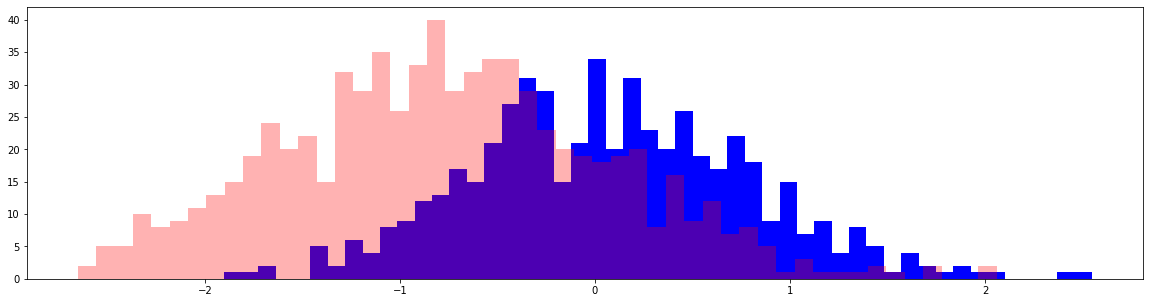

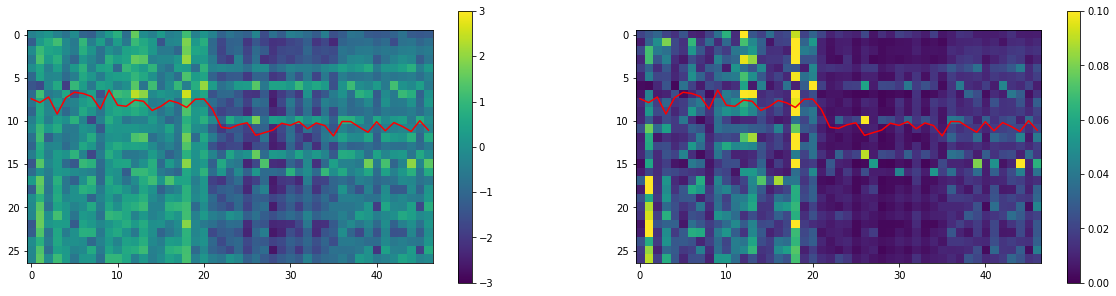

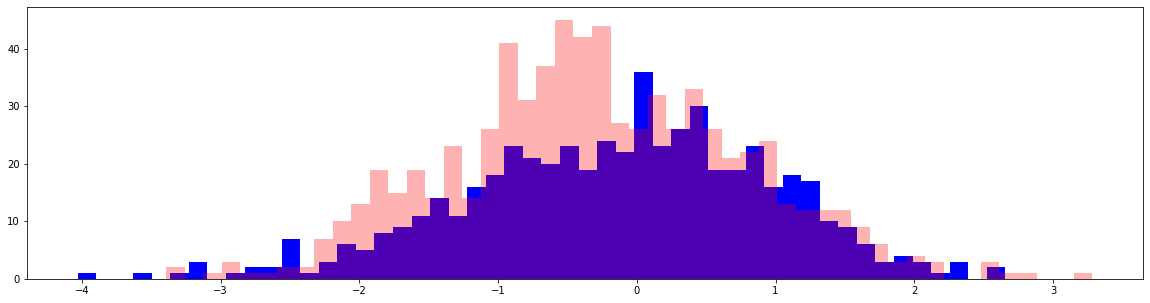

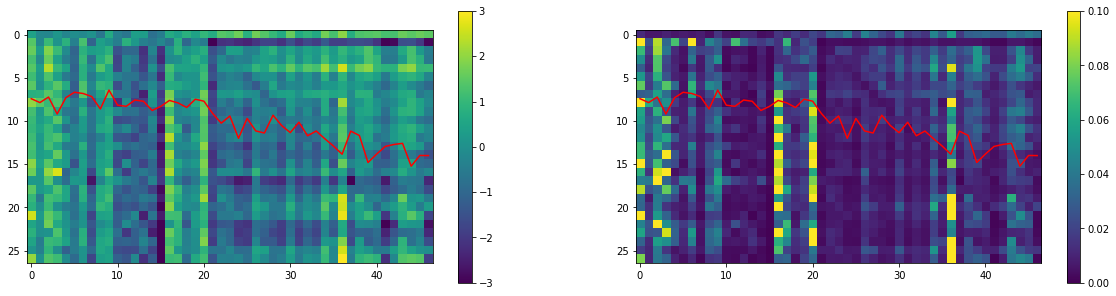

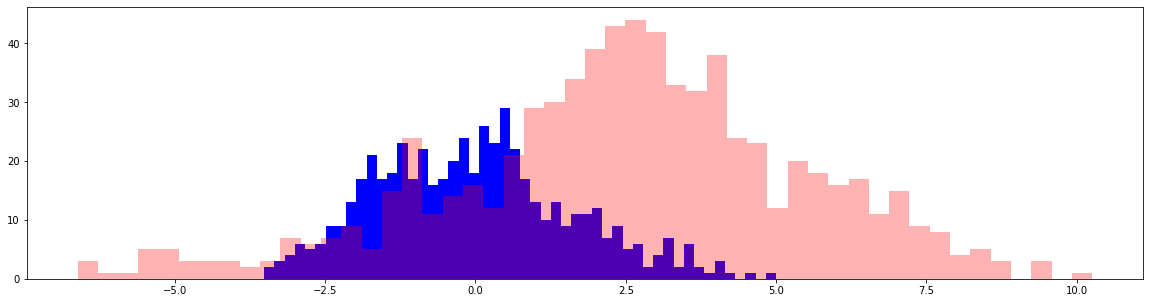

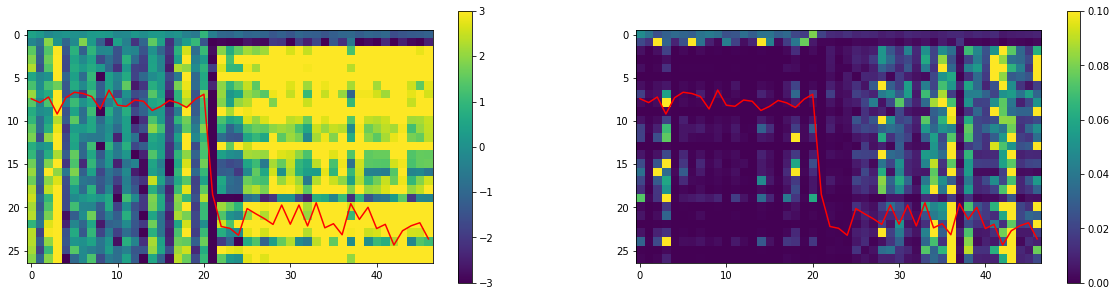

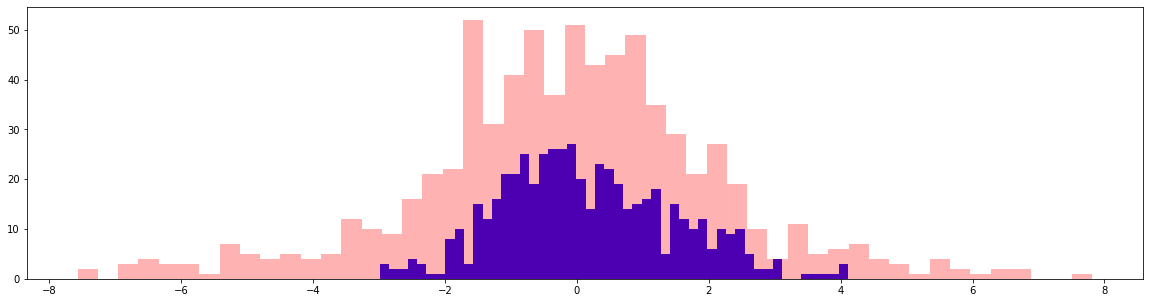

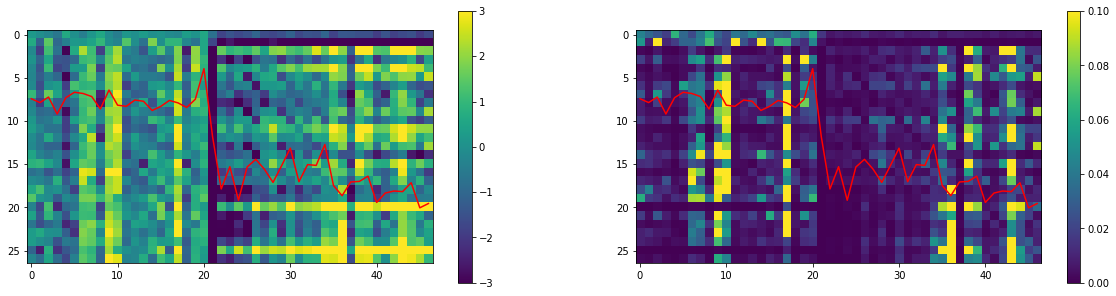

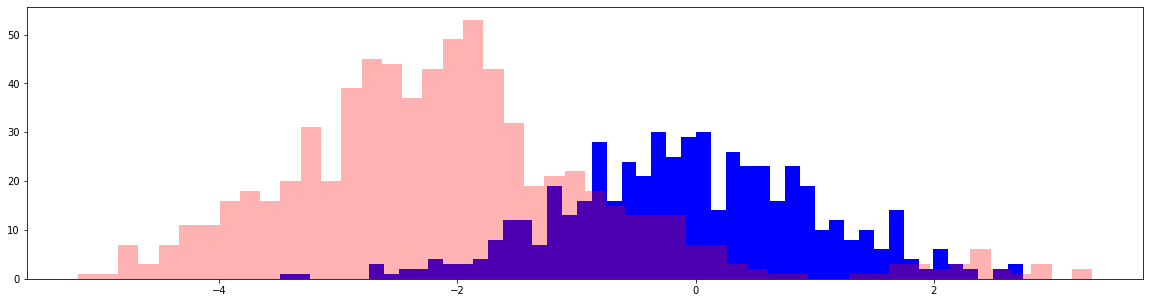

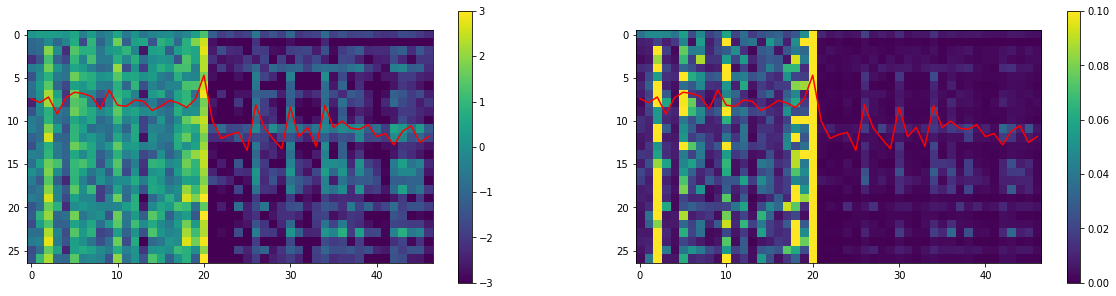

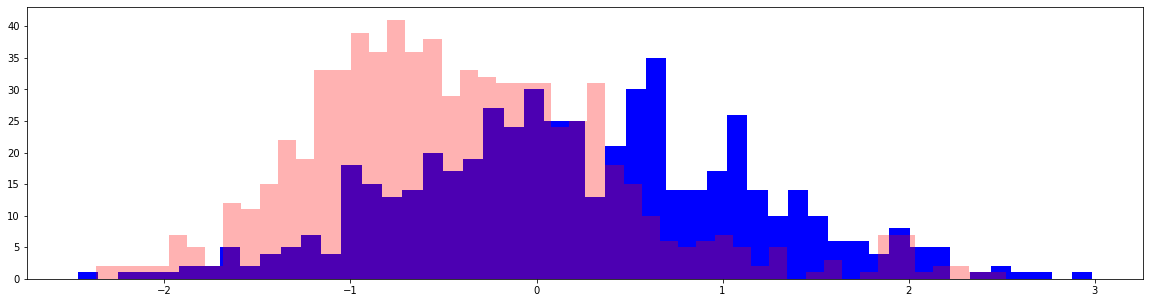

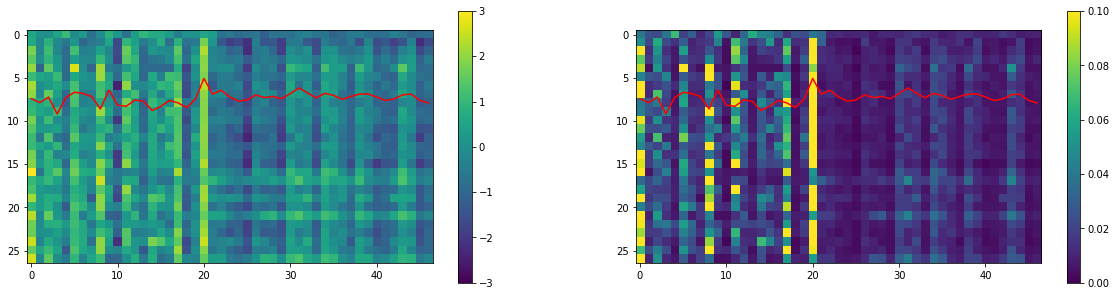

In [62]:
outputs = model.forward(input_ids=input_ids, past_key_values=None, output_attentions=True)

In [257]:
a = torch.randn(100, 1, 64)
b = torch.randn(1, 100, 64)

c = torch.cosine_similarity(a, b, dim=-1)

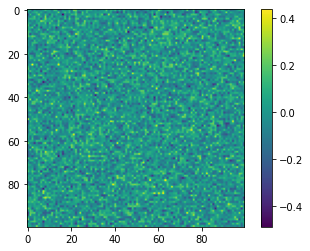

In [258]:
plt.imshow(to_np(c))
plt.colorbar()